# Setup

In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join("../../..")))  # access sibling directories
sys.path.append(os.path.abspath(os.path.join("../../../../BayesFlow_dev/BayesFlow/")))

from src.python.metrics import performance_metrics, bootstrapped_metrics
from src.python.helpers import log_with_inf_noise_addition, computation_times
from src.python.visualization import plot_approximations, plot_computation_times

import bayesflow as bf
import numpy as np

np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\lasse\projects\BayesFlow_dev\BayesFlow\bayesflow\trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Load data

In [2]:
comparison_folder = os.path.join(
    os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),
    "data",
    "02_bridge_sampling_comparison",
    "nested_models",
)
bridge_file = "2022_12_19_BF_BS"
NN_fixed_file = "2023_07_03_BF_NN_fixed"
NN_variable_file = "2023_07_03_BF_NN_variable"

bridge = pd.read_csv(os.path.join(comparison_folder, bridge_file), sep=" ").reset_index(
    drop=True
)
NN_fixed = pd.read_csv(os.path.join(comparison_folder, NN_fixed_file))
NN_variable = pd.read_csv(os.path.join(comparison_folder, NN_variable_file))


results_list = [bridge, NN_fixed, NN_variable]

# Calculate performance metrics

In [3]:
n_bootstrap = 1000
names = ["Bridge sampling", "Fixed network", "Variable network"]
metrics = ["Accuracy", "ROC AUC", "MAE", "RMSE", "Log score", "SBC"]

# Calculate performance metrics
perf_metrics = performance_metrics(
    results_list, names=names, metrics=metrics, model_prior=0.5
)

# Calculate bootstrapped performance metrics
metrics_means, metrics_ses = bootstrapped_metrics(
    results_list, 1000, names=names, metrics=metrics, model_prior=0.5
)

In [4]:
# Raw results
perf_metrics

,Accuracy,ROC AUC,MAE,RMSE,Log score,SBC
Bridge sampling,0.86,0.9176,0.187275,0.320515,0.317158,-0.017106
Fixed network,0.84,0.9164,0.187457,0.326202,0.324068,-0.016172
Variable network,0.86,0.9176,0.185328,0.320923,0.315792,-0.014379


In [5]:
# Bootstrapped means
metrics_means

,Accuracy,ROC AUC,MAE,RMSE,Log score,SBC
Bridge sampling,0.86101,0.918241,0.187133,0.317948,0.315656,-0.015860
Fixed network,0.84052,0.917222,0.187247,0.323539,0.322502,-0.014874
Variable network,0.86101,0.918402,0.185113,0.318221,0.314209,-0.013062


In [6]:
# Bootstrapped standard errors
metrics_ses

,Accuracy,ROC AUC,MAE,RMSE,Log score,SBC
Bridge sampling,0.034732,0.029964,0.025716,0.033722,0.057715,0.039201
Fixed network,0.036479,0.030087,0.026472,0.034557,0.059277,0.039628
Variable network,0.034732,0.029662,0.025948,0.034155,0.057823,0.039463


In [7]:
# Convert to latex table
metrics_means = metrics_means.round(2).drop(
    "ROC AUC", axis=1
)  # drop ROC AUC column as results do not add much information
metrics_ses = metrics_ses.round(2).drop(
    "ROC AUC", axis=1
)  # drop ROC AUC column as results do not add much information

for row in range(metrics_means.shape[0]):
    for col in range(metrics_means.shape[1]):
        metrics_means.iloc[row, col] = (
            f"{metrics_means.iloc[row,col]}" + f" ({metrics_ses.iloc[row,col]})"
        )

print(
    metrics_means.style.to_latex(position="h", position_float="centering", hrules=True)
)

\begin{table}[h]
\centering
\begin{tabular}{llllll}
\toprule
 & Accuracy & MAE & RMSE & Log score & SBC \\
\midrule
Bridge sampling & 0.86 (0.03) & 0.19 (0.03) & 0.32 (0.03) & 0.32 (0.06) & -0.02 (0.04) \\
Fixed network & 0.84 (0.04) & 0.19 (0.03) & 0.32 (0.03) & 0.32 (0.06) & -0.01 (0.04) \\
Variable network & 0.86 (0.03) & 0.19 (0.03) & 0.32 (0.03) & 0.31 (0.06) & -0.01 (0.04) \\
\bottomrule
\end{tabular}
\end{table}



In [8]:
# How do the proportions of selected models look like?

print("True proportion = {}".format(bridge["true_model"].mean()))
print("Bridge Sampling proportion = {}".format(bridge["selected_model"].mean()))
print("NN fixed proportion = {}".format(NN_fixed["selected_model"].mean()))
print("NN variable proportion = {}".format(NN_variable["selected_model"].mean()))

True proportion = 0.5
Bridge Sampling proportion = 0.46
NN fixed proportion = 0.46
NN variable proportion = 0.46


# Plot PMPs & log BFs

In [9]:
def log_with_inf_noise_additionx(x, noise=sys.float_info.min):
    """
    Adjusts the model probabilities leading to Inf values by a minimal amount of noise,
    recomputes the Bayes factors and then computes the log of the given array.
    """

    x_copy = x.copy()
    for i in range(x.shape[0]):
        if x.loc[i, "m0_prob"] == 0:
            print("Dataset with infinite BF: {}".format(i))
            x_copy.loc[i, "m0_prob"] = x_copy.loc[i, "m0_prob"] + noise
            x_copy.loc[i, "m1_prob"] = x_copy.loc[i, "m1_prob"] - noise
            x_copy.loc[i, "bayes_factor"] = (
                x_copy.loc[i, "m1_prob"] / x_copy.loc[i, "m0_prob"]
            )
    x_copy = np.log(x_copy["bayes_factor"])
    return x_copy


In [10]:
# Compute Log BFs

log_bridge_bfs = log_with_inf_noise_addition(bridge)
log_NN_fixed_bfs = log_with_inf_noise_addition(NN_fixed)
log_NN_variable_bfs = log_with_inf_noise_addition(NN_variable)

Dataset with infinite BF: 10
Dataset with infinite BF: 46
Dataset with infinite BF: 61
Dataset with infinite BF: 90


In [11]:
model_names = ["$\mathcal{M}_1$", "$\mathcal{M}_2$"]

## BS vs fixed NN

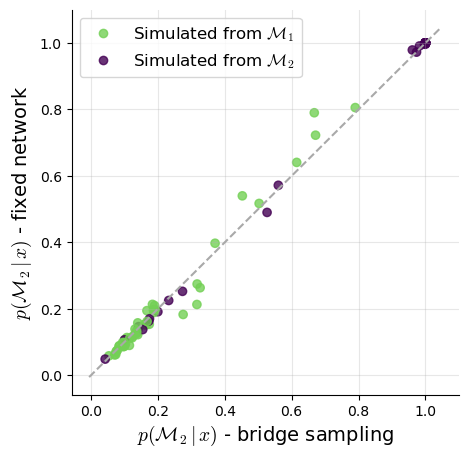

In [12]:
# PMPs
plot_approximations(
    bridge,
    NN_fixed,
    approximated_outcome="PMPs",
    NN_name="fixed network",
    model_names=model_names,
    save=False,
)

Dataset with infinite BF: 10
Dataset with infinite BF: 46
Dataset with infinite BF: 61
Dataset with infinite BF: 90


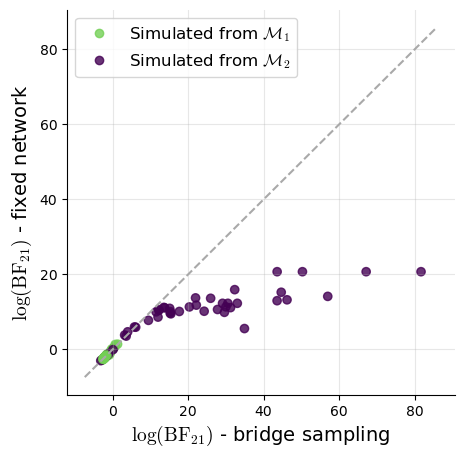

In [37]:
# Log BFs
plot_approximations(
    bridge,
    NN_fixed,
    approximated_outcome="Log BFs",
    NN_name="fixed network",
    model_names=model_names,
    save=True,
)

# of included datasets: 73


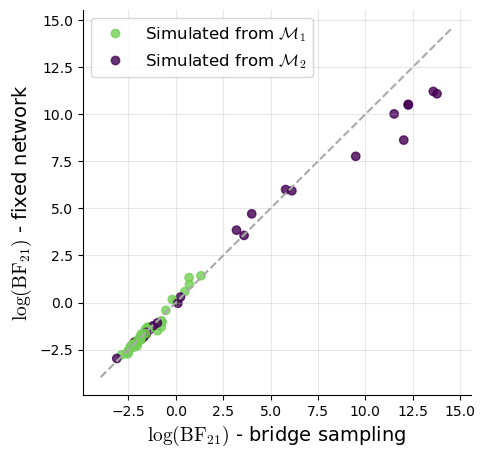

In [14]:
# Log Bfs with filter
filter = bridge["bayes_factor"] < 1000000
bridge_filtered = bridge[filter].reset_index(drop=True)
NN_fixed_filtered = NN_fixed[filter].reset_index(drop=True)
print("# of included datasets: {}".format(sum(filter)))

plot_approximations(
    bridge_filtered,
    NN_fixed_filtered,
    approximated_outcome="Log BFs",
    NN_name="fixed network",
    model_names=model_names,
    save=False,
)

## BS vs variable NN

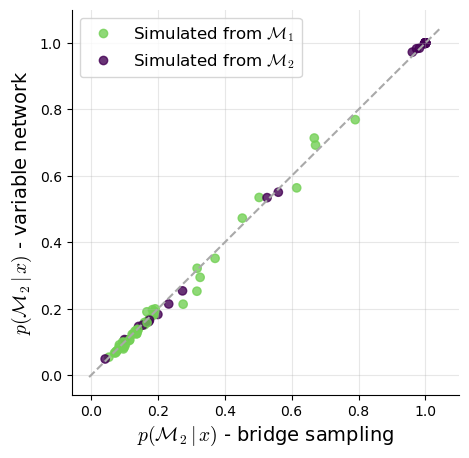

In [15]:
# PMPs
plot_approximations(
    bridge,
    NN_variable,
    approximated_outcome="PMPs",
    NN_name="variable network",
    model_names=model_names,
    save=False,
)

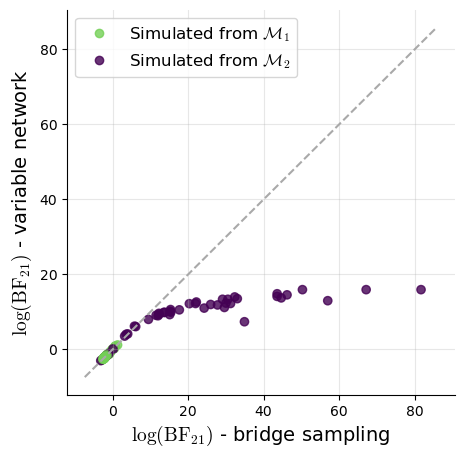

In [36]:
# Log BFs
plot_approximations(
    bridge,
    NN_variable,
    approximated_outcome="Log BFs",
    NN_name="variable network",
    model_names=model_names,
    save=True,
)

# of included datasets: 73


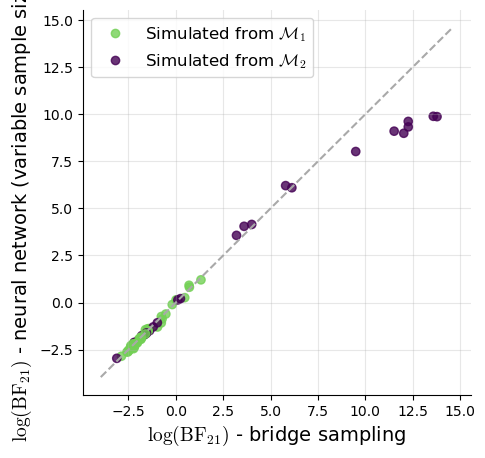

In [17]:
# Log Bfs with filter
filter = bridge["bayes_factor"] < 1000000
bridge_filtered = bridge[filter].reset_index(drop=True)
NN_variable_filtered = NN_variable[filter].reset_index(drop=True)
print("# of included datasets: {}".format(sum(filter)))

plot_approximations(
    bridge_filtered,
    NN_variable_filtered,
    approximated_outcome="Log BFs",
    NN_name="neural network (variable sample sizes)",
    model_names=model_names,
    save=False,
)

# Plot together for publication

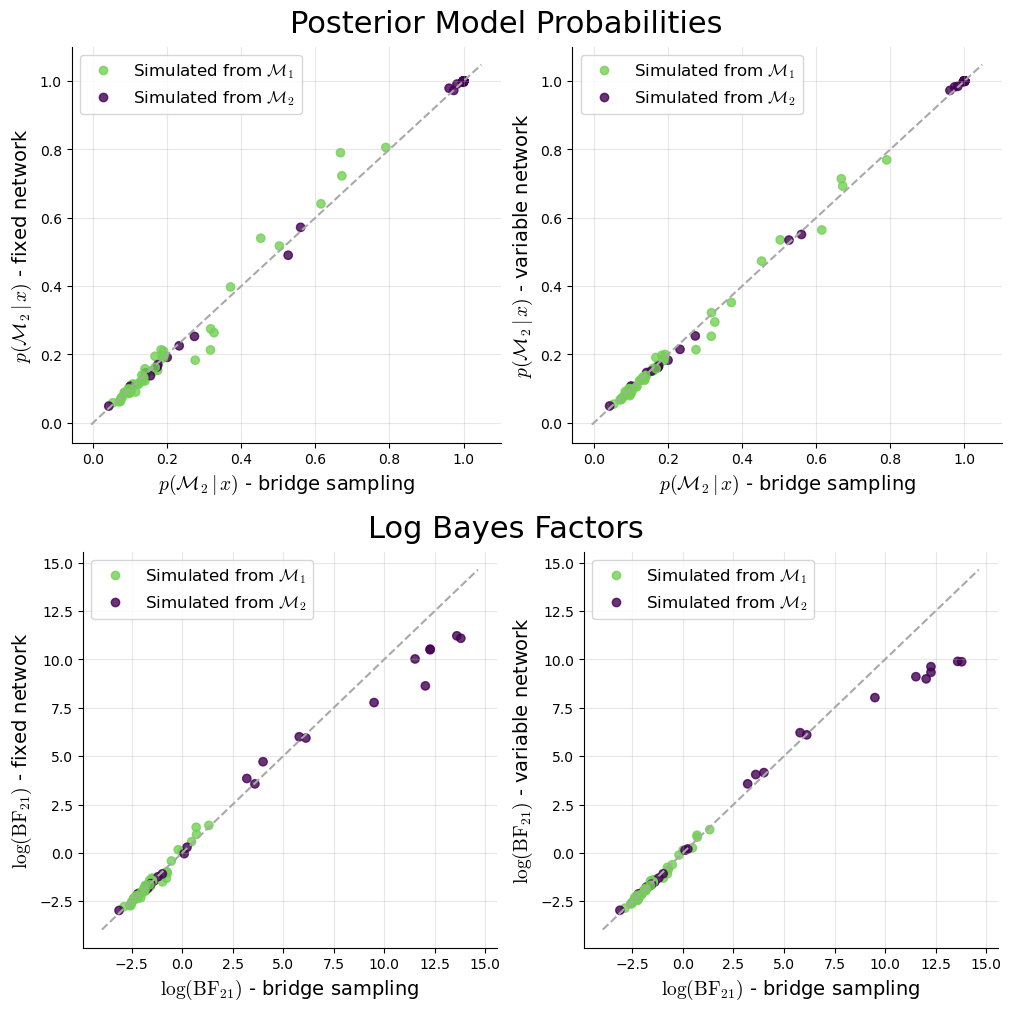

In [18]:
# Plot with PMP/log BF suptitles

fig = plt.figure(constrained_layout=True, figsize=(10, 10))
subfigs = fig.subfigures(nrows=2, ncols=1)
subfigure_titles = ["Posterior Model Probabilities", "Log Bayes Factors"]

bridge_list = [bridge, bridge_filtered]
NN_fixed_list = [NN_fixed, NN_fixed_filtered]
NN_variable_list = [NN_variable, NN_variable_filtered]

outcomes = ["PMPs", "Log BFs"]

# Use subfig to enable row titles
for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfigure_titles[row], fontsize=22)

    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)

    plot_approximations(
        bridge_list[row],
        NN_fixed_list[row],
        approximated_outcome=outcomes[row],
        NN_name="fixed network",
        model_names=model_names,
        ax=axs[0],
    )
    plot_approximations(
        bridge_list[row],
        NN_variable_list[row],
        approximated_outcome=outcomes[row],
        NN_name="variable network",
        model_names=model_names,
        ax=axs[1],
    )

plt.savefig("bs_comparison_convergence.pdf", dpi=300, bbox_inches="tight")

In [19]:
# map log BF where divergence starts (9.49) to BF and PMP
print(np.exp(9.49))  # BF
print(np.exp(9.49) / (np.exp(9.49) + 1))  # PMP

13226.795326641039
0.9999244016122637


# Find biggest discrepancies and compare implications

In [20]:
# Find biggest PMP discrepancies
divergence_fixed = np.argmax(abs(bridge["m1_prob"] - NN_fixed["m1_prob"]))
divergence_variable = np.argmax(abs(bridge["m1_prob"] - NN_variable["m1_prob"]))

In [21]:
np.sort(abs(bridge["m1_prob"] - NN_fixed["m1_prob"]))

array([0.        , 0.        , 0.        , 0.        , 0.00000012,
       0.00000024, 0.00000072, 0.00000107, 0.00000119, 0.00000179,
       0.00000226, 0.00000453, 0.00000453, 0.00000453, 0.00000739,
       0.00001168, 0.00001192, 0.00001222, 0.00001423, 0.00001431,
       0.00001714, 0.00002201, 0.00002297, 0.00002348, 0.00003458,
       0.00003743, 0.00003991, 0.00004127, 0.00005019, 0.00006163,
       0.0000749 , 0.00017281, 0.0003484 , 0.0004526 , 0.00055929,
       0.00078866, 0.0008033 , 0.00095171, 0.00265153, 0.00306405,
       0.00339425, 0.00344821, 0.00377345, 0.00391824, 0.00398814,
       0.00404481, 0.00404801, 0.004152  , 0.00485064, 0.00515197,
       0.00519071, 0.00548768, 0.00573478, 0.00575058, 0.00582288,
       0.00624435, 0.00627717, 0.00653029, 0.00706499, 0.00730757,
       0.00744442, 0.00756824, 0.00797654, 0.00848125, 0.00874932,
       0.00883718, 0.00896994, 0.00918251, 0.00927913, 0.00974953,
       0.00994018, 0.01029684, 0.01037217, 0.01095073, 0.01161

In [22]:
# Look up respective PMPs: Bridge vs. fixed network
print(f'PMP Bridge sampling: {bridge.loc[divergence_fixed, "m1_prob"]}')
print(f'PMP NN fixed: {NN_fixed.loc[divergence_fixed, "m1_prob"]}')

PMP Bridge sampling: 0.667725326426574
PMP NN fixed: 0.7901176810264587


In [23]:
# Look up respective BFs: Bridge vs. fixed network
print(f'BF Bridge sampling: {bridge.loc[divergence_fixed, "bayes_factor"]}')
print(f'BF NN fixed: {NN_fixed.loc[divergence_fixed, "bayes_factor"]}')

BF Bridge sampling: 2.00955829478832
BF NN fixed: 3.764574762136417


In [24]:
# Look up respective PMPs: Bridge vs. variable network
print(f'PMP Bridge sampling: {bridge.loc[divergence_variable, "m1_prob"]}')
print(f'PMP NN variable: {NN_variable.loc[divergence_variable, "m1_prob"]}')

PMP Bridge sampling: 0.316779572028838
PMP NN variable: 0.2529882788658142


In [25]:
# Look up respective BFs: Bridge vs. variable network
print(f'BF Bridge sampling: {bridge.loc[divergence_variable, "bayes_factor"]}')
print(f'BF NN variable: {NN_variable.loc[divergence_variable, "bayes_factor"]}')

BF Bridge sampling: 0.463656470239118
BF NN variable: 0.338667094707489


# Plot computation times as function of data sets

In [26]:
# Calculate computation times
results_time_list = computation_times(results_list)

In [27]:
# Mean computation times per phase
# Bridge Sampling
print(
    "Stan: {}seconds / {}minutes".format(
        round(np.mean(bridge["stan_time"]), 2),
        round((np.mean(bridge["stan_time"]) / 60), 2),
    )
)
print(
    "Bridge: {}seconds / {}minutes".format(
        round(np.mean(bridge["bridge_time"]), 2),
        round((np.mean(bridge["bridge_time"]) / 60), 2),
    )
)

# NN fixed
print(
    "NN fixed training: {}seconds / {}minutes".format(
        round(np.mean(NN_fixed["training_time"]), 2),
        round(np.mean(NN_fixed["training_time"]) / 60),
        2,
    )
)
print("NN fixed inference: {}seconds".format(np.mean(NN_fixed["inference_time"])))

# NN variable
print(
    "NN variable training: {}seconds / {}minutes".format(
        round(np.mean(NN_variable["training_time"]), 2),
        round(np.mean(NN_variable["training_time"]) / 60),
        2,
    )
)
print("NN variable inference: {}seconds".format(np.mean(NN_variable["inference_time"])))

Stan: 52.19seconds / 0.87minutes
Bridge: 38.46seconds / 0.64minutes
NN fixed training: 334.66seconds / 6minutes
NN fixed inference: 0.00043875399998789984seconds
NN variable training: 2165.06seconds / 36minutes
NN variable inference: 0.0066568039999401seconds


In [28]:
(np.mean(NN_fixed["training_time"]) + np.sum(NN_fixed["inference_time"]))

334.6998122999976

In [29]:
9065.88 / 60

151.09799999999998

In [30]:
# Total times

# Bridge Sampling
print(
    "Stan+Bridge: {}seconds / {}minutes".format(
        round(np.sum(bridge["bridge_time"]) + np.sum(bridge["stan_time"]), 2),
        round((np.sum(bridge["bridge_time"]) + np.sum(bridge["stan_time"])) / 60),
        2,
    )
)

# NN fixed
print(
    "NN fixed training+inference: {}seconds / {}minutes".format(
        round(
            (np.mean(NN_fixed["training_time"]) + np.sum(NN_fixed["inference_time"])), 2
        ),
        round(
            (np.mean(NN_fixed["training_time"]) + np.sum(NN_fixed["inference_time"]))
            / 60
        ),
        2,
    )
)

# NN variable
print(
    "NN fixed training+inference: {}seconds / {}minutes".format(
        round(
            (
                np.mean(NN_variable["training_time"])
                + np.sum(NN_variable["inference_time"])
            ),
            2,
        ),
        round(
            (
                np.mean(NN_variable["training_time"])
                + np.sum(NN_variable["inference_time"])
            )
            / 60
        ),
        2,
    )
)

Stan+Bridge: 9065.88seconds / 151minutes
NN fixed training+inference: 334.7seconds / 6minutes
NN fixed training+inference: 2165.73seconds / 36minutes


In [31]:
9142 / 60

152.36666666666667

In [32]:
# Stan compilation time in seconds
results_list[0]["compile_time"]

0     42.408955
1     42.408955
2     42.408955
3     42.408955
4     42.408955
        ...    
95    42.408955
96    42.408955
97    42.408955
98    42.408955
99    42.408955
Name: compile_time, Length: 100, dtype: float64

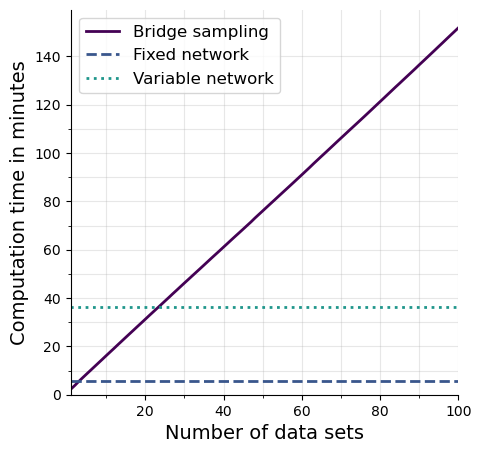

In [33]:
plot_computation_times(results_time_list, names=names, save=True)

In [34]:
results_time_list

[1        2.324134
 2        3.841673
 3        5.479971
 4        7.028234
 5        8.549732
           ...    
 96     145.655486
 97     147.208420
 98     148.752472
 99     150.272595
 100    151.804835
 Length: 100, dtype: float64,
 1      5.577606
 2      5.577614
 3      5.577621
 4      5.577628
 5      5.577636
          ...   
 96     5.578301
 97     5.578308
 98     5.578316
 99     5.578323
 100    5.578330
 Length: 100, dtype: float64,
 1      36.084493
 2      36.084604
 3      36.084715
 4      36.084826
 5      36.084937
          ...    
 96     36.095033
 97     36.095144
 98     36.095255
 99     36.095366
 100    36.095477
 Length: 100, dtype: float64]

In [35]:
# Get minimum number of datasets for which NNs are faster than bridge sampling

print(
    np.where(results_time_list[0] > results_time_list[1])[0][0] + 1
)  # +1 as numpy uses 0-based indexing
print(
    np.where(results_time_list[0] > results_time_list[2])[0][0] + 1
)  # +1 as numpy uses 0-based indexing

4
24
